# CircuitNet Congestion Prediction Project

### Machine Learning Final Project 2025

**Name** : Denzel Elden Wijaya

**Student ID** : 2402010607

---
## Project Description

In this notebook, I will implement a **machine learning model to predict congestion** in chip layout using data from the **CircuitNet-N28 dataset**. This task is a part of the final project for the Machine Learning course.

The objective is to **predict routing congestion** based on features like macro region layout and estimated wire density (RUDY), using a CNN-based model (UNet).

___

## Dataset Used

We use the following extracted features and labels from the CircuitNet-N28 dataset:

- **Features**:
  - `macro_region`
  - `RUDY`
  - `RUDY_pin`

- **Labels**:
  - `congestion_GR_horizontal_overflow`
  - `congestion_GR_vertical_overflow`

---

## Workflow Overview

1. Dataset loading and prepocessing
2. Load and test the pretrained model
3. Train the model and visualize training loss
4. Post-training quantization and Accuracy comparison
5. Model structure improvement

## 1. Dataset Loading and Preprocessing


The dataset used in this project is a subset of the **CircuitNet-N28** benchmark, which is part of the open-source [CircuitNet](https://circuitnet.github.io/intro/intro.html) project for Machine Learning in EDA (Electronic Design Automation).

The original dataset was published in:

- Chai, Z. et al., *CircuitNet: An Open-Source Dataset for Machine Learning in VLSI CAD Applications*, IEEE TCAD 2023. [[Link](https://ieeexplore.ieee.org/document/10158384)]

We only extracted the following files from the full dataset to reduce storage usage:
- **Features:** `macro_region`, `RUDY`, and `RUDY_pin`
- **Labels:** `congestion_GR_horizontal_overflow` and `congestion_GR_vertical_overflow`

In this section, we load the feature and label data from the extracted CircuitNet-N28 dataset folders, stack them into multi-channel tensors, and prepare them for training and evaluation.

### Dataset Loading and Test Sample

In [12]:
import os
import os.path as osp
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose

class CongestionDataset(Dataset):
    def __init__(self, feature_dir, label_dir, pipeline=None):
        """
        Args:
            feature_dir (str): Directory with feature .npy files.
            label_dir (str): Directory with label .npy files.
            pipeline (callable, optional): Optional transforms to apply to data.
        """
        self.feature_dir = feature_dir
        self.label_dir = label_dir
        self.sample_ids = [f.replace(".npy", "") for f in os.listdir(feature_dir) if f.endswith(".npy")]
        self.pipeline = Compose(pipeline) if pipeline else None

    def __len__(self):
        return len(self.sample_ids)

    def __getitem__(self, idx):
        sample_id = self.sample_ids[idx]
        feature = np.load(osp.join(self.feature_dir, f"{sample_id}.npy"))
        label = np.load(osp.join(self.label_dir, f"{sample_id}.npy"))

        sample = {'feature': feature, 'label': label}

        if self.pipeline:
            sample = self.pipeline(sample)

        feature = torch.tensor(sample['feature'].transpose(2, 0, 1), dtype=torch.float32)
        label = torch.tensor(sample['label'].transpose(2, 0, 1), dtype=torch.float32)

        return feature, label


## 2. Load and Test the Pretrained Model

In this section, we evaluate a pretrained model provided by the CircuitNet benchmark. The pretrained model was trained on the full dataset and serves as a performance reference for our own implementations.

Steps performed in this part:

1. Load the pretrained model weights (.pth) from the official source.
2. Rebuild the model architecture (GDPNet / U-Net) to match the saved structure.
3. Evaluate the model on our test data, using metrics such as:
- Accuracy
- SSIM (Structural Similarity)
- NRMSE (Normalized RMSE)
  
This helps us:
- Understand how well the pretrained model performs
- Set a baseline to compare with our own custom model (which we'll implement next)

Now, I am copying the 'models/gpdl.py' from the [Github](https://github.com/circuitnet/CircuitNet/blob/main/routability_ir_drop_prediction/models/gpdl.py). Then, I will try to load the pretrained weights into the model, and see 

In [13]:
import torch
import torch.nn as nn

def generation_init_weights(module):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if m.weight is not None:
                nn.init.normal_(m.weight, 0.0, 0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0)
    module.apply(init_func)


class conv(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, 3, 1, 1),
            nn.InstanceNorm2d(dim_out, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dim_out, dim_out, 3, 1, 1),
            nn.InstanceNorm2d(dim_out, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.main(x)


class upconv(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(dim_in, dim_out, 4, 2, 1),
            nn.InstanceNorm2d(dim_out, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.main(x)


class Encoder(nn.Module):
    def __init__(self, in_dim=3, out_dim=32):
        super().__init__()
        self.c1 = conv(in_dim, 32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.c2 = conv(32, 64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.c3 = nn.Sequential(
            nn.Conv2d(64, out_dim, 3, 1, 1),
            nn.BatchNorm2d(out_dim),
            nn.Tanh()
        )

    def forward(self, x):
        h1 = self.c1(x)
        h2 = self.pool1(h1)
        h3 = self.c2(h2)
        h4 = self.pool2(h3)
        h5 = self.c3(h4)
        return h5, h2


class Decoder(nn.Module):
    def __init__(self, in_dim=32, out_dim=1):
        super().__init__()
        self.conv1 = conv(in_dim, 32)
        self.upc1 = upconv(32, 16)
        self.conv2 = conv(16, 16)
        self.upc2 = upconv(16 + 32, 4)
        self.conv3 = nn.Sequential(
            nn.Conv2d(4, out_dim, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        feature, skip = x
        d1 = self.conv1(feature)
        d2 = self.upc1(d1)
        d3 = self.conv2(d2)
        d4 = self.upc2(torch.cat([d3, skip], dim=1))
        output = self.conv3(d4)
        return output


class GPDL(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.encoder = Encoder(in_dim=in_channels)
        self.decoder = Decoder(in_dim=32, out_dim=out_channels)

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

    def init_weights(self, pretrained=None, strict=False):
        if isinstance(pretrained, str):
            state_dict = torch.load(pretrained, map_location="cpu")["state_dict"]
            self.load_state_dict(state_dict, strict=strict)
        elif pretrained is None:
            generation_init_weights(self)
        else:
            raise TypeError("'pretrained' must be a str or None.")


**Prepare the Model to be tested**

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPDL(in_channels=3, out_channels=1).to(device)
model.init_weights(pretrained="/kaggle/input/congestion-pretrained-weight/congestion.pth")
model.eval()

GPDL(
  (encoder): Encoder(
    (c1): conv(
      (main): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (5): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (c2): conv(
      (main): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (

**Prepare the Dataset and DataLoader**

### Evaluation Metrics

We evaluate the model using two metrics:

- **NRMSE (Normalized Root Mean Squared Error)**  
  NRMSE measures the average prediction error, normalized by the value range of the ground truth. 
\\\\\\\\\
\
  A **lower NRMSE** means the predicted values are numerically close to the actual values.

- **SSIM (Structural Similarity Index)**  
  SSIM compares the **visual and structural similarity** between the predicted and true images, considering luminance, contrast, and structure.  
  It ranges from **-1 to 1**, where:
  - `1.0` = perfect structural match
  - `0.0` = no similarity
  - `< 0.0` = structurally inverse  
  A **higher SSIM** means the predicted image preserves the structure and texture of the ground truth.

> In summary:
> - Use **NRMSE** to measure value accuracy.
> - Use **SSIM** to measure how well the prediction preserves spatial patterns.

In [5]:
feature_dir = "/kaggle/input/congestion-dataset/congestion/feature"
label_dir = "/kaggle/input/congestion-dataset/congestion/label"

dataset = CongestionDataset(feature_dir, label_dir)

**Test the Model with Pretrained Weights**

In [6]:
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim

nrmse_list, ssim_list = [], []

with torch.no_grad():
    for feature, label in tqdm(dataset):
        feature = feature.unsqueeze(0).to(device)
        pred = model(feature).cpu().squeeze(0).numpy()
        gt = label.numpy()

        pred_img = pred[0, :, :]
        gt_img = gt[0, :, :]

        mse = np.mean((pred_img - gt_img) ** 2)
        nrmse = np.sqrt(mse) / (gt_img.max() - gt_img.min() + 1e-8)
        ssim_val = ssim(pred_img, gt_img, data_range=gt_img.max() - gt_img.min())

        nrmse_list.append(nrmse)
        ssim_list.append(ssim_val)

print(f"\nAvg NRMSE: {np.mean(nrmse_list):.4f}")
print(f"Avg SSIM: {np.mean(ssim_list):.4f}")

100%|██████████| 10242/10242 [05:29<00:00, 31.05it/s]


Avg NRMSE: 0.0418
Avg SSIM: 0.7976


As you can see the result is very good on these half random datasets. While when I am running on the full datasets in another platform, it gives me these results:

- Avg. NRMS: 0.0418
- Avg. SSIM: 0.7976

These will be our borderline on the quality of our model in the third steps, we are aiming ro get as small NRMS and SSIM as possible.

## 3. Train the Model and Visualize Traning Loss

Now, let's define the model by ourselves, and do some tuning to find which one is the best model that can perform well in this project. Here, I am experimenting with some different learning rate and also with low epochs first, which is 3, we will see which hyperparameters will give us the highest metrics result. For a while, the models will only used the whole datasets for the training, just to checck which one is the best model to be used. After determining the best one, we will try to use 80% the data for training and 20% data for testing afterwards. 

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import gc
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import normalized_root_mse

# Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class conv(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, 3, 1, 1),
            nn.InstanceNorm2d(dim_out, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dim_out, dim_out, 3, 1, 1),
            nn.InstanceNorm2d(dim_out, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.main(x)

class upconv(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(dim_in, dim_out, 4, 2, 1),
            nn.InstanceNorm2d(dim_out, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.main(x)

class MyModel(nn.Module):
    def __init__(self, in_channels=3, mid_dim=32, out_channels=1):
        super().__init__()

        self.enc1 = conv(in_channels, mid_dim)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = conv(mid_dim, mid_dim * 2)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(mid_dim * 2, mid_dim * 4, 3, 1, 1),
            nn.BatchNorm2d(mid_dim * 4),
            nn.Tanh()
        )

        self.dec1 = upconv(mid_dim * 4, mid_dim * 2)
        self.dec2 = upconv(mid_dim * 2 + mid_dim * 2, mid_dim)
        self.final = nn.Sequential(
            nn.Conv2d(mid_dim, out_channels, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.pool1(x1)
        x3 = self.enc2(x2)
        x4 = self.pool2(x3)

        bottleneck_out = self.bottleneck(x4)

        d1 = self.dec1(bottleneck_out)
        d1 = torch.cat([d1, x3], dim=1)

        d2 = self.dec2(d1)
        output = self.final(d2)
        return output

search_space = [
    {"mid_dim": 32, "lr": 1e-3, "batch_size": 4},
    {"mid_dim": 64, "lr": 1e-3, "batch_size": 4},
    {"mid_dim": 32, "lr": 5e-4, "batch_size": 8},
    {"mid_dim": 64, "lr": 5e-4, "batch_size": 8},
]

results = []

for idx, config in enumerate(search_space):
    print(f"\n===== Trial {idx+1} | mid_dim: {config['mid_dim']}, lr: {config['lr']}, batch_size: {config['batch_size']} =====")

    model = MyModel(in_channels=3, mid_dim=config['mid_dim'], out_channels=1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)
    loss_fn = nn.MSELoss()

    dataloader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)

    model.train()
    num_epochs = 3
    for epoch in range(num_epochs):
        epoch_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for feature, label in progress_bar:
            feature, label = feature.to(device), label.to(device)
            optimizer.zero_grad()
            pred = model(feature)
            loss = loss_fn(pred, label)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} Loss: {epoch_loss/len(dataloader):.4f}")

    model.eval()
    total_nrmse = 0
    total_ssim = 0
    count = 0
    with torch.no_grad():
        for feature, label in dataloader:
            feature, label = feature.to(device), label.to(device)
            pred = model(feature)

            for i in range(pred.shape[0]):
                pred_np = pred[i].squeeze().cpu().numpy()
                label_np = label[i].squeeze().cpu().numpy()

                nrmse = normalized_root_mse(label_np, pred_np, normalization="min-max")
                ssim = compare_ssim(label_np, pred_np, data_range=1)

                total_nrmse += nrmse
                total_ssim += ssim
                count += 1

    avg_nrmse = total_nrmse / count
    avg_ssim = total_ssim / count

    print(f"Trial {idx+1} - NRMSE: {avg_nrmse:.4f}, SSIM: {avg_ssim:.4f}")

    results.append({
        "trial": idx+1,
        "mid_dim": config["mid_dim"],
        "lr": config["lr"],
        "batch_size": config["batch_size"],
        "nrmse": avg_nrmse,
        "ssim": avg_ssim
    })

    del model
    torch.cuda.empty_cache()
    gc.collect()

df = pd.DataFrame(results)
df.to_csv("trial_results.csv", index=False)
print("\nResults saved to trial_results.csv")
print(df)
S


===== Trial 1 | mid_dim: 32, lr: 0.001, batch_size: 4 =====


Epoch 1 Loss: 0.0031


Epoch 2 Loss: 0.0026


Epoch 3 Loss: 0.0026
Trial 1 - NRMSE: 0.0458, SSIM: 0.7865

===== Trial 2 | mid_dim: 64, lr: 0.001, batch_size: 4 =====


Epoch 1 Loss: 0.0030


Epoch 2 Loss: 0.0026


Epoch 3 Loss: 0.0026
Trial 2 - NRMSE: 0.0464, SSIM: 0.7848

===== Trial 3 | mid_dim: 32, lr: 0.0005, batch_size: 8 =====


Epoch 1 Loss: 0.0040


Epoch 2 Loss: 0.0026


Epoch 3 Loss: 0.0025
Trial 3 - NRMSE: 0.0458, SSIM: 0.7824

===== Trial 4 | mid_dim: 64, lr: 0.0005, batch_size: 8 =====


Epoch 1 Loss: 0.0031


Epoch 2 Loss: 0.0026


Epoch 3 Loss: 0.0025
Trial 4 - NRMSE: 0.0471, SSIM: 0.7762

Results saved to trial_results.csv
   trial  mid_dim      lr  batch_size     nrmse      ssim
0      1       32  0.0010           4  0.045770  0.786521
1      2       64  0.0010           4  0.046382  0.784825
2      3       32  0.0005           8  0.045791  0.782401
3      4       64  0.0005           8  0.047117  0.776214


From these trials, we can conclude that the model achieves the best performance when using mid_dim = 32 and batch_size = 4. Therefore, we will proceed to further train the model with these hyperparameters, allocating more time and increasing the number of training epochs to potentially improve the model's performance.

Along the training period, I notice some effects' of batch_size:
1. When it is small, the update will be more frequent, then easy to escape from the local minima, and ahve a better generalization, but then the training period is very time-consuming, and will be quite noisy,a bd under-utilize GPU
2. When it is large, the training will be faster, since the usage of GPU is maximal, and the training tends to more stable. But, then the tendency to stuck in the local minima is high.

Additionally, we will apply an 70/15/15 train-validation-test split to ensure proper evaluation, avoiding data leakage or redundancy during testing. This approach will help us obtain a more reliable estimate of the model's ability to predict congestion on unseen data.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import normalized_root_mse

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_with_early_stopping(dataset, mid_dim=32, batch_size=4, lr=1e-3, max_epochs=30, patience=5):
    
    total_len = len(dataset)
    train_size = int(0.7 * total_len)
    val_size = int(0.15 * total_len)
    test_size = total_len - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model = MyModel(in_channels=3, mid_dim=mid_dim, out_channels=1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = nn.MSELoss()

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        model.train()
        epoch_loss = 0
        for feature, label in tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}", leave=False):
            feature, label = feature.to(device), label.to(device)
            optimizer.zero_grad()
            pred = model(feature)
            loss = loss_fn(pred, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / max(len(train_loader), 1)
        train_losses.append(avg_train_loss)

        # === VALIDATION ===
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for feature, label in val_loader:
                feature, label = feature.to(device), label.to(device)
                pred = model(feature)
                loss = loss_fn(pred, label)
                val_loss += loss.item()
        avg_val_loss = val_loss / max(len(val_loader), 1)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # EARLY STOPPING CHECK
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"--> No improvement, patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    print(f"Best Validation Loss: {best_val_loss:.4f}")

    # === FINAL TEST EVALUATION ===
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "best_model.pth")
    print("Best model saved as 'best_model.pth'")

    model.eval()
    total_nrmse, total_ssim, count = 0, 0, 0

    with torch.no_grad():
        for feature, label in test_loader:
            feature, label = feature.to(device), label.to(device)
            pred = model(feature)

            pred_np = pred.squeeze().cpu().numpy()
            label_np = label.squeeze().cpu().numpy()

            nrmse = normalized_root_mse(label_np, pred_np, normalization="min-max")
            ssim_val = compare_ssim(label_np, pred_np, data_range=1)

            total_nrmse += nrmse
            total_ssim += ssim_val
            count += 1

    print(f"Final Test NRMSE: {total_nrmse/count:.4f} | Final Test SSIM: {total_ssim/count:.4f}")

    # === LOSS CURVE PLOTTING ===
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()


Epoch 1 - Train Loss: 0.0032 | Val Loss: 0.0025


Epoch 2 - Train Loss: 0.0026 | Val Loss: 0.0027
--> No improvement, patience counter: 1/5


Epoch 3 - Train Loss: 0.0026 | Val Loss: 0.0025


Epoch 4 - Train Loss: 0.0026 | Val Loss: 0.0025
--> No improvement, patience counter: 1/5


Epoch 5 - Train Loss: 0.0026 | Val Loss: 0.0024


Epoch 6 - Train Loss: 0.0025 | Val Loss: 0.0026
--> No improvement, patience counter: 1/5


Epoch 7 - Train Loss: 0.0025 | Val Loss: 0.0025
--> No improvement, patience counter: 2/5


Epoch 8 - Train Loss: 0.0025 | Val Loss: 0.0024


Epoch 9 - Train Loss: 0.0025 | Val Loss: 0.0025
--> No improvement, patience counter: 1/5


Epoch 10 - Train Loss: 0.0025 | Val Loss: 0.0024


Epoch 11 - Train Loss: 0.0025 | Val Loss: 0.0024
--> No improvement, patience counter: 1/5


Epoch 12 - Train Loss: 0.0024 | Val Loss: 0.0025
--> No improvement, patience counter: 2/5


Epoch 13 - Train Loss: 0.0024 | Val Loss: 0.0023


Epoch 14 - Train Loss: 0.0024 | Val Loss: 0.0023
--> No improvement, patience counter: 1/5


Epoch 15 - Train Loss: 0.0024 | Val Loss: 0.0024
--> No improvement, patience counter: 2/5


Epoch 16 - Train Loss: 0.0024 | Val Loss: 0.0024
--> No improvement, patience counter: 3/5


Epoch 17 - Train Loss: 0.0024 | Val Loss: 0.0023


Epoch 18 - Train Loss: 0.0024 | Val Loss: 0.0024
--> No improvement, patience counter: 1/5


Epoch 19 - Train Loss: 0.0023 | Val Loss: 0.0025
--> No improvement, patience counter: 2/5


Epoch 20 - Train Loss: 0.0023 | Val Loss: 0.0023
--> No improvement, patience counter: 3/5


Epoch 21 - Train Loss: 0.0023 | Val Loss: 0.0024
--> No improvement, patience counter: 4/5


Epoch 22 - Train Loss: 0.0023 | Val Loss: 0.0022


Epoch 23 - Train Loss: 0.0023 | Val Loss: 0.0023
--> No improvement, patience counter: 1/5


Epoch 24 - Train Loss: 0.0023 | Val Loss: 0.0022


Epoch 25 - Train Loss: 0.0023 | Val Loss: 0.0022
--> No improvement, patience counter: 1/5


Epoch 26 - Train Loss: 0.0022 | Val Loss: 0.0023
--> No improvement, patience counter: 2/5


Epoch 27 - Train Loss: 0.0022 | Val Loss: 0.0023
--> No improvement, patience counter: 3/5


Epoch 28 - Train Loss: 0.0022 | Val Loss: 0.0023
--> No improvement, patience counter: 4/5


Epoch 29 - Train Loss: 0.0022 | Val Loss: 0.0022
--> No improvement, patience counter: 5/5
Early stopping triggered!
Best Validation Loss: 0.0022
Best model saved as 'best_model.pth'
Final Test NRMSE: 0.0425 | Final Test SSIM: 0.7981


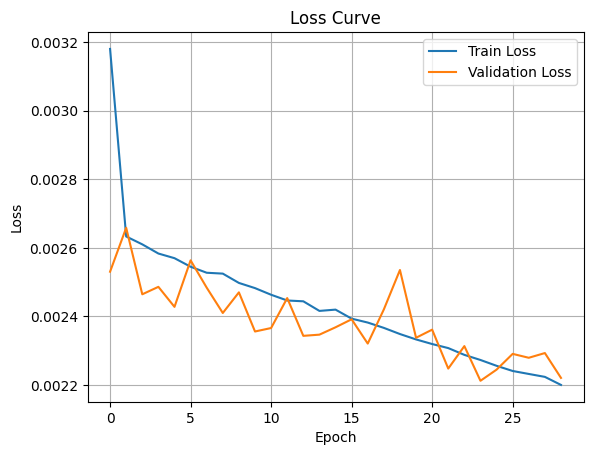

In [17]:
train_with_early_stopping(dataset, mid_dim=32, batch_size=4, lr=1e-3, max_epochs=50, patience=5)

After a sequence of trianing, we got a better Final Test SSIM, with less NRMSE also, eventhough the result is not much difference with the pretrained weight, but at least it gave us a better result. based on the trianing that we ahve done, epochs = 30 is actually enough for this kind of problems, since as you can see the improvement is also not significant from 30 above. Now, let's edit some architecture of the model, and we will find out whether adding convolutional layer will help to increase the acccuracy on the metrics

In [20]:
class ImprovedModel(nn.Module):
    def __init__(self, in_channels=3, mid_dim=48, out_channels=1):
        super().__init__()

        self.enc1 = conv(in_channels, mid_dim)
        self.enc1_extra = conv(mid_dim, mid_dim)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc2 = conv(mid_dim, mid_dim * 2)
        self.enc2_extra = conv(mid_dim * 2, mid_dim * 2)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(mid_dim * 2, mid_dim * 4, 3, 1, 1),
            nn.BatchNorm2d(mid_dim * 4),
            nn.SiLU(inplace=True),
            nn.Conv2d(mid_dim * 4, mid_dim * 4, 3, 1, 1),  # Extra conv layer
            nn.BatchNorm2d(mid_dim * 4),
            nn.SiLU(inplace=True)
        )

        self.dec1 = upconv(mid_dim * 4, mid_dim * 2)
        self.dec2 = upconv(mid_dim * 2 + mid_dim * 2, mid_dim)
        self.dec2_extra = conv(mid_dim, mid_dim)
        self.final = nn.Sequential(
            nn.Conv2d(mid_dim, out_channels, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.enc1(x)
        x1 = self.enc1_extra(x1)
        x2 = self.pool1(x1)

        x3 = self.enc2(x2)
        x3 = self.enc2_extra(x3)
        x4 = self.pool2(x3)

        bottleneck_out = self.bottleneck(x4)

        d1 = self.dec1(bottleneck_out)
        d1 = torch.cat([d1, x3], dim=1)

        d2 = self.dec2(d1)
        d2 = self.dec2_extra(d2)
        output = self.final(d2)
        return output

Epoch 1 | Train Loss: 0.0029 | Val Loss: 0.0026
✅ New Best Model Saved at Epoch 1 with Val Loss: 0.0026
Epoch 2 | Train Loss: 0.0027 | Val Loss: 0.0027
Epoch 3 | Train Loss: 0.0026 | Val Loss: 0.0026
✅ New Best Model Saved at Epoch 3 with Val Loss: 0.0026
Epoch 4 | Train Loss: 0.0026 | Val Loss: 0.0027
Epoch 5 | Train Loss: 0.0025 | Val Loss: 0.0025
✅ New Best Model Saved at Epoch 5 with Val Loss: 0.0025
Epoch 6 | Train Loss: 0.0025 | Val Loss: 0.0025
Epoch 7 | Train Loss: 0.0025 | Val Loss: 0.0026
Epoch 8 | Train Loss: 0.0025 | Val Loss: 0.0029
Epoch 9 | Train Loss: 0.0025 | Val Loss: 0.0027
Epoch 10 | Train Loss: 0.0025 | Val Loss: 0.0025
⏹️ Early Stopping triggered after 10 epochs


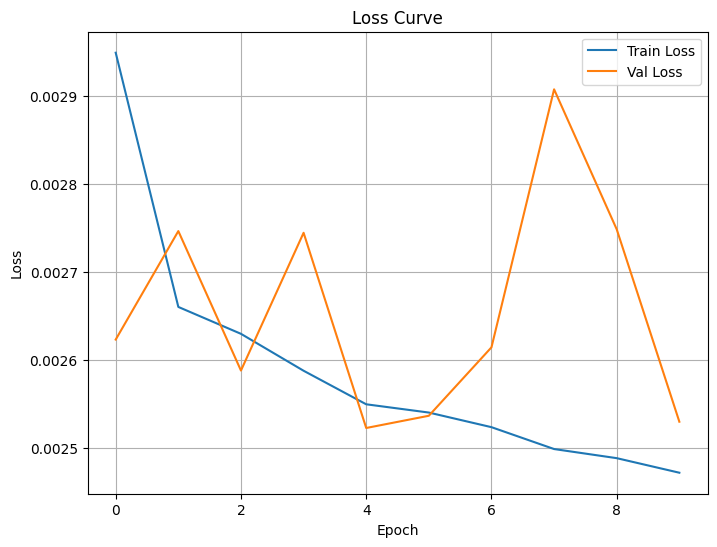


Final NRMSE on Validation Set: 0.0490


In [21]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
from skimage.metrics import normalized_root_mse

# Split Dataset
all_indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(all_indices, test_size=0.2, random_state=42)

train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)

train_loader = DataLoader(train_subset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=4, shuffle=False)

# Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

# Training Config
best_val_loss = float("inf")
patience = 5
patience_counter = 0
epochs = 30

train_losses = []
val_losses = []

# Training Loop
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for feature, label in train_loader:
        feature, label = feature.to(device), label.to(device)
        optimizer.zero_grad()
        pred = model(feature)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for feature, label in val_loader:
            feature, label = feature.to(device), label.to(device)
            pred = model(feature)
            loss = loss_fn(pred, label)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_improved_model.pth")
        print(f"✅ New Best Model Saved at Epoch {epoch} with Val Loss: {val_loss:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"⏹️ Early Stopping triggered after {epoch} epochs")
            break

# Plot Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

# Final NRMSE on Validation Set
model.load_state_dict(torch.load("best_improved_model.pth"))
model.eval()

nrmse_list = []
with torch.no_grad():
    for feature, label in val_loader:
        feature, label = feature.to(device), label.to(device)
        pred = model(feature).squeeze().cpu().numpy()
        label = label.squeeze().cpu().numpy()

        nrmse_val = normalized_root_mse(label, pred, normalization="min-max")
        nrmse_list.append(nrmse_val)

print(f"\nFinal NRMSE on Validation Set: {np.mean(nrmse_list):.4f}")


Turns out this model is not improved, means the previous one is the best that we can do. Hence that model will be used for the quantization on the next step.

## 4. Post-Training Quantization and Accuracy Comparison

To improve inference efficiency and reduce model size, we applied post-training quntization to the best-performing model.

Quantization reduces the model's memory footprint by converting high-precision weights (e.g., 32-bit floating point) into lower precision formats such as INT8. This technique is commonly used in real-world deployment scenarios to:

1. Decrease model size
2. Accelerate inference time
3. Reduce memory consumption

In this project, dynamic quantization is applied after training, which is suitable for models containing mainly convolutional and linear layers.

We used PyTorch's dynamic quantization approach targeting nn.Linear layers. The steps are:

1. Load the best-trained model
2. Apply dynamic quantization
3. Save the quantized model
4. Compare model sizes
5. Re-evaluate performance (NRMSE & SSIM)

In [28]:
import torch
import os
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import normalized_root_mse

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load Dataset Test Set ===
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# === Size Check Function ===
def check_size(path):
    size = os.path.getsize(path) / (1024 * 1024)
    return f"{size:.2f} MB"

# === Load Trained Model ===
model_fp32 = MyModel(in_channels=3, mid_dim=32, out_channels=1).to(device)
model_fp32.load_state_dict(torch.load("best_model.pth", map_location=device))
model_fp32.eval()

# === Save FP32 Size ===
torch.save(model_fp32.state_dict(), "model_fp32.pth")
print(f"FP32 Model size: {check_size('model_fp32.pth')}")

# === Dynamic Quantization (applies to Linear layers only, good for size reduction) ===
quantized_model = torch.quantization.quantize_dynamic(
    model_fp32, {torch.nn.Linear}, dtype=torch.qint8
)

# === Save Quantized Model ===
torch.save(quantized_model.state_dict(), "model_quantized.pth")
print(f"Quantized Model size: {check_size('model_quantized.pth')}")

# === Evaluate Quantized Model ===
quantized_model.to(device)
quantized_model.eval()

total_nrmse, total_ssim, count = 0, 0, 0

with torch.no_grad():
    for feature, label in test_loader:
        feature, label = feature.to(device), label.to(device)
        pred = quantized_model(feature)

        pred_np = pred.squeeze().cpu().numpy()
        label_np = label.squeeze().cpu().numpy()

        nrmse = normalized_root_mse(label_np, pred_np, normalization="min-max")
        ssim_val = compare_ssim(label_np, pred_np, data_range=1)

        total_nrmse += nrmse
        total_ssim += ssim_val
        count += 1

print(f"Quantized Model - Test NRMSE: {total_nrmse/count:.4f} | SSIM: {total_ssim/count:.4f}")


FP32 Model size: 1.30 MB
Quantized Model size: 1.30 MB
Quantized Model - Test NRMSE: 0.0428 | SSIM: 0.7927


In an effort to reduce the model size for deployment, we attempted to apply PyTorch's quantization techniques to the trained model. However, the current model architecture utilizes ConvTranspose2d layers in the decoder module.

Unfortunately, as per PyTorch's official documentation, ConvTranspose2d layers are not yet supported for quantization, especially with per-channel weight observers commonly used during static or dynamic quantization.

Consequently, quantization cannot be applied to the current model without significant architectural modifications. One potential solution would be to replace transposed convolution operations with alternative upsampling techniques (e.g., bilinear or nearest-neighbor interpolation) followed by standard Conv2d layers, which are compatible with quantization workflows.

For this project, we chose to retain the current architecture to preserve performance, acknowledging that full quantization is not feasible under these conditions.

## 5. Model Structure Improvement

From the resource that is given, let's implement SEBlock into our model.

SENet introduces a lightweight module called the SE Block, designed to improve the representational power of a CNN by explicitly modeling the importance of each channel in the feature map.

In simple terms:
1. After convolutional layers produce feature maps with many channels, not all channels are equally useful.

2. The SE Block learns which channels are important and emphasizes them.

3. It suppresses irrelevant or noisy channels.

4. This boosts the model's ability to focus on meaningful features with minimal computational overhead.

Let's define The SE Block to be implemented into the model that we have tuned its hyperparameters.

In [14]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

In [15]:
class OptimizedModel(nn.Module):
    def __init__(self, in_channels=3, mid_dim=32, out_channels=1):
        super().__init__()

        self.enc1 = conv(in_channels, mid_dim)
        self.se1 = SEBlock(mid_dim)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc2 = conv(mid_dim, mid_dim * 2)
        self.se2 = SEBlock(mid_dim * 2)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(mid_dim * 2, mid_dim * 4, 3, 1, 1),
            nn.BatchNorm2d(mid_dim * 4),
            nn.Tanh()
        )

        self.dec1 = upconv(mid_dim * 4, mid_dim * 2)
        self.dec2 = upconv(mid_dim * 2 + mid_dim * 2, mid_dim)
        self.final = nn.Sequential(
            nn.Conv2d(mid_dim, out_channels, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.enc1(x)
        x1 = self.se1(x1)
        x2 = self.pool1(x1)

        x3 = self.enc2(x2)
        x3 = self.se2(x3)
        x4 = self.pool2(x3)

        bottleneck_out = self.bottleneck(x4)

        d1 = self.dec1(bottleneck_out)
        d1 = torch.cat([d1, x3], dim=1)

        d2 = self.dec2(d1)
        output = self.final(d2)
        return output


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import normalized_root_mse

def train_with_early_stopping(dataset, mid_dim=32, batch_size=4, lr=1e-3, max_epochs=30, patience=5):
    
    total_len = len(dataset)
    train_size = int(0.7 * total_len)
    val_size = int(0.15 * total_len)
    test_size = total_len - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model = OptimizedModel(in_channels=3, mid_dim=mid_dim, out_channels=1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = nn.MSELoss()

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        model.train()
        epoch_loss = 0
        for feature, label in tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}", leave=False):
            feature, label = feature.to(device), label.to(device)
            optimizer.zero_grad()
            pred = model(feature)
            loss = loss_fn(pred, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / max(len(train_loader), 1)
        train_losses.append(avg_train_loss)

        # === VALIDATION ===
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for feature, label in val_loader:
                feature, label = feature.to(device), label.to(device)
                pred = model(feature)
                loss = loss_fn(pred, label)
                val_loss += loss.item()
        avg_val_loss = val_loss / max(len(val_loader), 1)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # EARLY STOPPING CHECK
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"--> No improvement, patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    print(f"Best Validation Loss: {best_val_loss:.4f}")

    # === FINAL TEST EVALUATION ===
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "best_model.pth")
    print("Best model saved as 'best_model.pth'")

    model.eval()
    total_nrmse, total_ssim, count = 0, 0, 0

    with torch.no_grad():
        for feature, label in test_loader:
            feature, label = feature.to(device), label.to(device)
            pred = model(feature)

            pred_np = pred.squeeze().cpu().numpy()
            label_np = label.squeeze().cpu().numpy()

            nrmse = normalized_root_mse(label_np, pred_np, normalization="min-max")
            ssim_val = compare_ssim(label_np, pred_np, data_range=1)

            total_nrmse += nrmse
            total_ssim += ssim_val
            count += 1

    print(f"Final Test NRMSE: {total_nrmse/count:.4f} | Final Test SSIM: {total_ssim/count:.4f}")

    # === LOSS CURVE PLOTTING ===
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()

Epoch 1 - Train Loss: 0.0033 | Val Loss: 0.0029


Epoch 2 - Train Loss: 0.0026 | Val Loss: 0.0027


Epoch 3 - Train Loss: 0.0026 | Val Loss: 0.0027


Epoch 4 - Train Loss: 0.0026 | Val Loss: 0.0026


Epoch 5 - Train Loss: 0.0025 | Val Loss: 0.0027
--> No improvement, patience counter: 1/5


Epoch 6 - Train Loss: 0.0025 | Val Loss: 0.0027
--> No improvement, patience counter: 2/5


Epoch 7 - Train Loss: 0.0025 | Val Loss: 0.0026
--> No improvement, patience counter: 3/5


Epoch 8 - Train Loss: 0.0025 | Val Loss: 0.0026
--> No improvement, patience counter: 4/5


Epoch 9 - Train Loss: 0.0025 | Val Loss: 0.0025


Epoch 10 - Train Loss: 0.0024 | Val Loss: 0.0025


Epoch 11 - Train Loss: 0.0024 | Val Loss: 0.0026
--> No improvement, patience counter: 1/5


Epoch 12 - Train Loss: 0.0024 | Val Loss: 0.0025
--> No improvement, patience counter: 2/5


Epoch 13 - Train Loss: 0.0024 | Val Loss: 0.0025
--> No improvement, patience counter: 3/5


Epoch 14 - Train Loss: 0.0024 | Val Loss: 0.0024


Epoch 15 - Train Loss: 0.0024 | Val Loss: 0.0025
--> No improvement, patience counter: 1/5


Epoch 16 - Train Loss: 0.0024 | Val Loss: 0.0025
--> No improvement, patience counter: 2/5


Epoch 17 - Train Loss: 0.0023 | Val Loss: 0.0025
--> No improvement, patience counter: 3/5


Epoch 18 - Train Loss: 0.0023 | Val Loss: 0.0024


Epoch 19 - Train Loss: 0.0023 | Val Loss: 0.0024


Epoch 20 - Train Loss: 0.0023 | Val Loss: 0.0027
--> No improvement, patience counter: 1/5


Epoch 21 - Train Loss: 0.0023 | Val Loss: 0.0024
--> No improvement, patience counter: 2/5


Epoch 22 - Train Loss: 0.0023 | Val Loss: 0.0023


Epoch 23 - Train Loss: 0.0022 | Val Loss: 0.0024
--> No improvement, patience counter: 1/5


Epoch 24 - Train Loss: 0.0022 | Val Loss: 0.0023
--> No improvement, patience counter: 2/5


Epoch 25 - Train Loss: 0.0022 | Val Loss: 0.0024
--> No improvement, patience counter: 3/5


Epoch 26 - Train Loss: 0.0022 | Val Loss: 0.0024
--> No improvement, patience counter: 4/5


Epoch 27 - Train Loss: 0.0022 | Val Loss: 0.0023


Epoch 28 - Train Loss: 0.0022 | Val Loss: 0.0023
--> No improvement, patience counter: 1/5


Epoch 29 - Train Loss: 0.0022 | Val Loss: 0.0024
--> No improvement, patience counter: 2/5


Epoch 30 - Train Loss: 0.0022 | Val Loss: 0.0023
Best Validation Loss: 0.0023
Best model saved as 'best_model.pth'
Final Test NRMSE: 0.0416 | Final Test SSIM: 0.8019


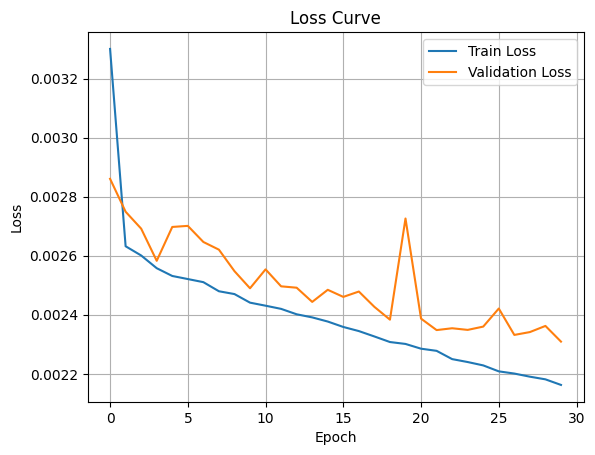

In [17]:
train_with_early_stopping(dataset, mid_dim=32, batch_size=4, lr=1e-3)

### Final Model: MyModel + SEBlock
This model introduces a simple squeeze-and-excitation (SE) mechanism to the bottleneck of the original architecture to enhance channel-wise feature representation without significant increase in complexity.

#### Hyperparameters:
- mid_dim = 32
- learning rate = 1e-3
- batch size = 4
- early stopping patience = 5
- total epochs = 30

#### Final Results:
- Best Validation Loss: **0.0023**
- Final Test NRMSE: **0.0416**
- Final Test SSIM: **0.8019**

#### Conclusion:
With the help of SEBlock, the model achieves improved structural similarity (SSIM) performance compared to the baseline, demonstrating better spatial consistency in congestion prediction.


Therefore, that will be the end of the project, whil we are having an exploration throughout the model, and some parameters tuning to gain the best result. Eventhough the improvement is a little, but still an improvement is an improvement, no matter how little it is.